In [1]:
#pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

##### Target variable: Attrition_Flag. 0 == existing customer, 1 == attrited customer

In [3]:
df = pd.read_csv('/work/Cleaned_data.csv')
df

,Attrition_Flag,Customer_Age,Dependent_count,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,...,Gender_M,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,3,5,1,3,12691.0,777,1.335,1144,...,1,1,0,0,1,0,0,0,0,0
1,0,49,5,6,1,2,8256.0,864,1.541,1291,...,0,0,1,0,0,0,1,0,0,0
2,0,51,3,4,1,0,3418.0,0,2.594,1887,...,1,1,0,0,0,1,0,0,0,0
3,0,40,4,3,4,1,3313.0,2517,1.405,1171,...,0,1,0,0,0,0,1,0,0,0
4,0,40,3,5,1,0,4716.0,0,2.175,816,...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0,50,2,3,2,3,4003.0,1851,0.703,15476,...,1,0,1,1,0,0,0,0,0,0
10123,1,41,2,4,2,3,4277.0,2186,0.804,8764,...,1,0,0,1,0,0,0,0,0,0
10124,1,44,1,5,3,4,5409.0,0,0.819,10291,...,0,1,0,0,0,0,1,0,0,0
10125,1,30,2,4,3,3,5281.0,0,0.535,8395,...,1,1,0,1,0,0,0,0,0,0


## Split Data: Train & Test

#### Train - 70%, Test - 20%, Valid - 10%

In [4]:
X = df.iloc[:, 1:] # All columns except the target variable
y = df.iloc[:, 0]  # The target variable

# Shuffle data to reduce bias and avoid uneven distribution across the train, test, and validation sets 
df = df.sample(frac=1, random_state=42) # "frac=1" ensures that the entire DataFrame is sampled, effectively shuffling the rows

# First, split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)
 
# Then split the remaining data into test and valid
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.3333)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(7088, 23)
(7088,)
(2026, 23)
(2026,)
(1013, 23)
(1013,)


(None, None)

## Balancing Classes

In [5]:
# Count the number of observations in each class
class_counts = df['Attrition_Flag'].value_counts()
class_counts

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

Severe class imbalance detected

In [6]:
# Check the class distribution of the training set
print("Class distribution in the training set:\n", y_train.value_counts())

# Perform oversampling using the RandomOverSampler class
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Print the class distribution of the oversampled training set
print("Class distribution in the oversampled training set (after oversampling):\n", pd.Series(y_train_oversampled).value_counts())

# Perform undersampling using the RandomUnderSampler class
undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Print the class distribution of the undersampled training set
print("Class distribution in the undersampled training set (after undersampling):\n", pd.Series(y_train_undersampled).value_counts())

Class distribution in the training set:
 0    5974
1    1114
Name: Attrition_Flag, dtype: int64
Class distribution in the oversampled training set (after oversampling):
 0    5974
1    5974
Name: Attrition_Flag, dtype: int64
Class distribution in the undersampled training set (after undersampling):
 0    1114
1    1114
Name: Attrition_Flag, dtype: int64


#### Oversampling

In [7]:
# oversample the minority class (Attrition_Flag = 1) in the training data using SMOTE
#The fit_resample method of the SMOTE object performs both oversampling and undersampling 
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42) #  set sampling_strategy='auto' to perform oversampling only
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

#### Assigning Weight

Use weighted approach to balance the data: the model assigns a higher weight to the minority class samples during training which gives them more influence on the model's parameters.

Let's set the weight for the minor class to be the inverse of its proportion in the training set

In [8]:
# weight = minor/major ratio
# weight = (total samples) / (2 * number of samples in minor class)
# weight = (5970 + 1118) / (2 * 1118) = 3.167 

# Calculate the class weights
class_weight = {0: 1, 1: 3.167} 

## Evaluate the Model Function

 The evaluate_model function takes the trained model and the train/test data as inputs and prints the evaluation metrics while returning the confusion matrix, precision, recall, and F1 score.

In [9]:
def evaluate_model(model, X_test, y_test):
    # Predict on the test data using the trained model
    y_pred = model.predict(X_test)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Compute precision, recall, and F1 score
    accuracy_test = model.score(X_test, y_test)
    accuracy_train = model.score(X_train, y_train)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    # Print the results
    print("Accuracy_train:", "{:.4f}".format(accuracy_train))
    print("Accuracy_test:", "{:.4f}".format(accuracy_test))
    #print("Confusion Matrix:")
    #print(conf_matrix)
    print("Precision:", "{:.4f}".format(precision))
    print("Recall:", "{:.4f}".format(recall))
    print("F1 Score:", "{:.4f}".format(f1))
    
    # Return the evaluation metrics
    return conf_matrix, precision, recall, f1

In [10]:
def evaluate_model_train(model, X_train, y_train):
    # Predict on the test data using the trained model
    y_pred = model.predict(X_train)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_train, y_train)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)

    f1 = f1_score(y_train, y_pred)

    # Print the results
    print("Train Precision:", "{:.4f}".format(precision))
    print("Train Recall:", "{:.4f}".format(recall))
    print("Train F1 Score:", "{:.4f}".format(f1))
    
    # Return the evaluation metrics
    return precision, recall, f1

In [11]:
def evaluate_model_valid(model, X_valid, y_valid):
    # Predict on the test data using the trained model
    y_pred = model.predict(X_valid)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_valid, y_valid)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)

    f1 = f1_score(y_valid, y_pred)

    # Print the results
    print("Valid Precision:", "{:.4f}".format(precision))
    print("Valid Recall:", "{:.4f}".format(recall))
    print("Valid F1 Score:", "{:.4f}".format(f1))
    
    # Return the evaluation metrics
    return precision, recall, f1

#### Note:
##### Accuracy - (TP + TN) / (P + N). 
Measures the number of correct predictions made by a model in relation to the total number of predictions made.

##### Recall - TP / (TP + FN). 
(also known as sensitivity) Measures the ability of the model to correctly identify all positive instances in the data. A high recall score indicates that the model is good at identifying positive cases, but may have a higher false positive rate. 
This one is more important for the bank as they want to predict the % of people stay in the bank who actually stay in the bank

##### Precision - TP / (TP + FP). 
Measures the ability of the model to correctly identify true positive cases without falsely predicting too many cases as positive. A high precision score indicates that the model is good at predicting positive cases, but may have a higher false negative rate. 
In our case it is how many people stay in the bank and we predict that they stay.

##### F1 score - 2 TP / (2 TP + FP + FN)
harmonic mean of precision and recall. It combines both metrics to provide a single score that balances the importance of precision and recall. A high F1 score indicates that the model is good at both identifying positive cases and avoiding false positives.

In the case of credit card churner, true positive = existing; false positive = customer who left, which is more important. 
#### Recall >>> precision.

The result is an array of probability. We need to set the threshold (the probability of someone will leave the bank) of what is considered "will leave the bank". Find the one that maximizes the precision and recall.

## Logistic Regression

#### Raw Data

In [12]:
# Build a logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = logistic_model.predict(X_test)

evaluate_model(logistic_model, X_test, y_test)

Accuracy_train: 0.8892
Accuracy_test: 0.8825
Precision: 0.7458
Recall: 0.4972
F1 Score: 0.5966
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([[806,  30],
        [ 89,  88]]),
 0.7457627118644068,
 0.4971751412429379,
 0.5966101694915255)

#### Oversampled Data

In [13]:
# Build a logistic regression model on the oversampled data
logistic_model_oversampled = LogisticRegression()
logistic_model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Predict on the test data using the trained model
y_pred = logistic_model_oversampled.predict(X_test)

evaluate_model(logistic_model_oversampled, X_test, y_test)

Accuracy_train: 0.8181
Accuracy_test: 0.8263
Precision: 0.5017
Recall: 0.8192
F1 Score: 0.6223
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([[692, 144],
        [ 32, 145]]),
 0.5017301038062284,
 0.8192090395480226,
 0.6223175965665236)

#### Weighted Data

In [14]:
# Build a logistic regression model with class weights
logistic_model_weighted = LogisticRegression(class_weight=class_weight)
logistic_model_weighted.fit(X_train, y_train)

# Predict on the test data using the trained model
y_pred = logistic_model_weighted.predict(X_test)

evaluate_model(logistic_model_weighted, X_test, y_test)

Accuracy_train: 0.8513
Accuracy_test: 0.8628
Precision: 0.5826
Recall: 0.7571
F1 Score: 0.6585


(array([[740,  96],
        [ 43, 134]]),
 0.5826086956521739,
 0.7570621468926554,
 0.6584766584766584)

## Random Forest

#### Raw Data

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42) # the model should contain 100 trees
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

evaluate_model(rf_model, X_test, y_test)

Accuracy_train: 0.9224
Accuracy_test: 0.9210
Precision: 0.9533
Recall: 0.5763
F1 Score: 0.7183


(array([[831,   5],
        [ 75, 102]]),
 0.9532710280373832,
 0.576271186440678,
 0.7183098591549295)

#### Oversampled Data

In [16]:
rf_model_oversampled = RandomForestClassifier(n_estimators=100, random_state=42) # the model should contain 100 trees
rf_model_oversampled.fit(X_train_oversampled, y_train_oversampled)
y_pred = rf_model_oversampled.predict(X_test)

evaluate_model(rf_model_oversampled, X_test, y_test)

Accuracy_train: 1.0000
Accuracy_test: 0.9605
Precision: 0.8914
Recall: 0.8814
F1 Score: 0.8864


(array([[817,  19],
        [ 21, 156]]),
 0.8914285714285715,
 0.8813559322033898,
 0.8863636363636365)

#### Weighted Data

In [17]:
rf_model_weighted = RandomForestClassifier(n_estimators=100, random_state=42,class_weight=class_weight) # the model should contain 100 trees
rf_model_weighted.fit(X_train, y_train)
y_pred = rf_model_weighted.predict(X_test)

evaluate_model(rf_model_weighted, X_test, y_test)

Accuracy_train: 1.0000
Accuracy_test: 0.9536
Precision: 0.9276
Recall: 0.7966
F1 Score: 0.8571


(array([[825,  11],
        [ 36, 141]]),
 0.9276315789473685,
 0.7966101694915254,
 0.8571428571428572)

#### Hyperparameter Tuning

##### RF Feature Importance to pick one model to do hyper parameter tuning (validation set needed)

In [18]:
# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300],\
'max_depth': [5, 10, None],\
'min_samples_split': [2, 5, 10],\
'max_features': ['auto', 'sqrt', 0.5],\
'random_state': [42]}

# Create the random forest classifier
rf_model = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(rf_model, param_grid, cv=5)  # Use cross-validation for evaluation

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Create a new random forest model with the best parameters
best_rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],\
max_depth=best_params['max_depth'],\
min_samples_split=best_params['min_samples_split'],\
max_features=best_params['max_features'],\
random_state=best_params['random_state'])

# Train the model on the training data
best_rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = best_rf_model.predict(X_test)


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

In [25]:
# Evaluate the model using accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9684106614017769


In [26]:
evaluate_model(best_rf_model, X_test, y_test)

Accuracy_train: 1.0000
Accuracy_test: 0.9684
Precision: 0.9394
Recall: 0.8757
F1 Score: 0.9064


(array([[826,  10],
        [ 22, 155]]),
 0.9393939393939394,
 0.8757062146892656,
 0.9064327485380117)

#### Setting a Threshold
By default, the predict method in scikit-learn's RandomForestClassifier class uses a threshold of 0.5, where probabilities greater than or equal to 0.5 are predicted as class 1, and probabilities less than 0.5 are predicted as class 0.

In [29]:
# The predict_proba method returns the predicted probabilities for each class (existing customer and attrited customer) 
y_pred_proba = best_rf_model.predict_proba(X_test)

# Define the custom threshold to be smaller than 0.5 to more lenient
# If the probability for the positive class is >= threshold, it is classified as class 1 (attrited customer)
threshold = 0.3

# Apply the custom threshold to convert probabilities to binary predictions
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

from sklearn.metrics import accuracy_score
# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9693978282329714


In [30]:
evaluate_model(best_rf_model, X_test, y_test)

Accuracy_train: 1.0000
Accuracy_test: 0.9684
Precision: 0.9394
Recall: 0.8757
F1 Score: 0.9064


(array([[826,  10],
        [ 22, 155]]),
 0.9393939393939394,
 0.8757062146892656,
 0.9064327485380117)

By setting the threshold to 0.3, we are adopting a risk-embracing approach, favoring higher recall over precision. It means we are willing to predict more customers as attrited, even if some of them may turn out to be existing customers. This approach helps in identifying a larger proportion of attrited customers, but it may also result in more false positives.

#### Evaluate feature importance

Top 10 Most Important Features:
1. Total_Trans_Ct: 0.19891836549778072
2. Total_Trans_Amt: 0.19624922983851006
3. Total_Ct_Chng_Q4_Q1: 0.15242323371149913
4. Total_Revolving_Bal: 0.15175536099962814
5. Avg_Utilization_Ratio: 0.08024765450851594
6. Total_Relationship_Count: 0.07045830472215825
7. Total_Amt_Chng_Q4_Q1: 0.04195005159670009
8. Contacts_Count_12_mon: 0.03247642522791536
9. Credit_Limit: 0.025424961944613307
10. Months_Inactive_12_mon: 0.023012367818767743


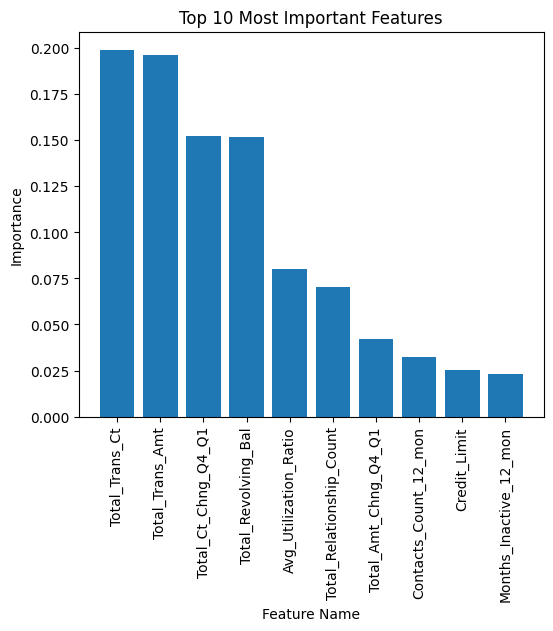

In [31]:
# Train the random forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importancess
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select top 10 most important features
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = X_train.columns[top_indices]

# Print feature importance ranking
print("Top 10 Most Important Features:")
for i, feature_name in enumerate(top_feature_names):
    print(f"{i + 1}. {feature_name}: {top_importances[i]}")

# Plot feature importances
plt.figure(figsize=(6, 5))
plt.title("Top 10 Most Important Features")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_feature_names, rotation='vertical')
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()


#### Apply Principal Component Analysis (PCA) for dimensionality feature reduction

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.datasets import load_iris
# import matplotlib.pyplot as plt



# # Create a PCA object with 5 components
# pca = PCA(n_components=5)

# # Apply PCA to the data
# X_pca = pca.fit_transform(X)

# # Plot the transformed data
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

In [34]:
# from sklearn.decomposition import PCA

# # Select top 10 most important features
# top_n = 10
# top_indices = indices[:top_n]

# # Retrieve the top feature subset
# top_features = X_train

# # Apply PCA for dimensionality reduction
# pca = PCA(n_components=5)  # Choose the desired number of components
# reduced_features = pca.fit_transform(top_features)

# # Create a new DataFrame with reduced features
# reduced_X_train = pd.DataFrame(data=reduced_features, columns=[f'PC{i+1}' for i in range(reduced_features.shape[1])])

# # Use reduced_X_train for further modeling or analysis
# rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
# rf_model.fit(reduced_X_train, y_train)

# # Make predictions on the reduced training set
# y_pred_train = rf_model.predict(reduced_X_train)

# # Transform the test set in the same way using the fitted PCA object
# # Apply PCA transformation on the test set
# reduced_features_test = pca.transform(X_test)

# # Create a new DataFrame with reduced features for the test set
# reduced_X_test = pd.DataFrame(data=reduced_features_test, columns=[f'PC{i+1}' for i in range(reduced_features_test.shape[1])])

# evaluate_model(rf_model, reduced_X_test, y_test)


## XGBoost

In [32]:
params = {
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.1,      # Learning rate
    'objective': 'binary:logistic',  # Objective function
    'eval_metric': 'logloss'          # Evaluation metric
}

#### Raw Data

In [33]:
# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier(**params)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

#conf_matrix, precision, recall, f1 = evaluate_model(xgb_model, X_train, y_train, X_test, y_test) --> why this does not work??

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 96.54%
Precision: 92.77%
Recall: 87.01%
F1 Score: 89.80%


#### Oversampled Data

In [34]:
# Create an instance of the XGBoost classifier
xgb_model_oversampled = xgb.XGBClassifier(**params)

# Train the XGBoost model
xgb_model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the test set
y_pred = xgb_model_oversampled.predict(X_test)

#conf_matrix, precision, recall, f1 = evaluate_model(xgb_model, X_train, y_train, X_test, y_test) --> why this does not work??

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 96.45%
Precision: 86.91%
Recall: 93.79%
F1 Score: 90.22%


#### Weighted Data

In [35]:
# Create an instance of the XGBoost classifier
xgb_model_weighted = xgb.XGBClassifier(**params, class_weight=class_weight)

# Train the XGBoost model
xgb_model_weighted.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model_weighted.predict(X_test)

#conf_matrix, precision, recall, f1 = evaluate_model(xgb_model, X_train, y_train, X_test, y_test) --> why this does not work??

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

[13:54:31] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

Accuracy: 96.54%
Precision: 92.77%
Recall: 87.01%
F1 Score: 89.80%


#### Hyperparameter Tuning

Selecting the best combination of hyperparameters for a machine learning algorithm to improve its performance on a given task. Hyperparameters are settings that cannot be learned from the data, but instead must be set before training the model. 

Grid search is a technique used to perform hyperparameter tuning by searching over a specified set of hyperparameters exhaustively. We define a grid of hyperparameter values and then evaluate the model's performance for each combination of hyperparameters in the grid. We then select the set of hyperparameters that yields the best performance on the test data.

##### Note:
estimator: This parameter specifies the model or estimator object to be tuned. In this case, it is set to xgb_model, which is an instance of the XGBoost classifier.

param_grid: This parameter defines the grid of hyperparameters to search over. It is a dictionary where the keys are the names of the hyperparameters, and the values are the corresponding values or a list of values to be tested. In this example, param_grid is set to the dictionary that contains different values for max_depth, learning_rate, and n_estimators that we want to search over.

scoring: This parameter specifies the scoring metric used to evaluate the performance of the model with different hyperparameter combinations. In this case, 'accuracy' is used as the scoring metric, which is a common choice for classification tasks. You can use other evaluation metrics like 'precision', 'recall', or 'f1' depending on your specific problem.

cv: This parameter determines the number of cross-validation folds to use for evaluation. It specifies how the dataset will be split into training and validation subsets. In this example, cv=3 indicates that the data will be divided into three folds, and the grid search will perform three rounds of training and evaluation.

In [36]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 7],             # Maximum depth of a tree
    'learning_rate': [0.1, 0.01, 0.001], # Learning rate
    'n_estimators': [100, 200, 300]     # Number of trees
}


# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)

# Perform grid search on the training data
grid_search.fit(X_train, y_train) # add weight_class to try

# Retrieve the best tuned model
xgb_model_tuned = grid_search.best_estimator_

# Print the best hyperparameters and best score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: %.4f" % grid_search.best_score_)


Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Score: 0.9694


train a new XGBoost model with the best hyperparameters obtained from grid search and evaluate its performance on unseen data

In [37]:
xgb_model_tuned = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=300)

xgb_model_tuned.fit(X_train, y_train)

y_pred = xgb_model_tuned.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# USE TEST OR VALID???
# y_pred = xgb_model_tuned.predict(X_valid)
# accuracy = accuracy_score(y_valid, y_pred)
# precision = precision_score(y_valid, y_pred)
# recall = recall_score(y_valid, y_pred)
# f1 = f1_score(y_valid, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 97.53%
Precision: 94.71%
Recall: 90.96%
F1 Score: 92.80%


In [38]:
evaluate_model_valid(xgb_model_tuned, X_valid, y_valid)

Valid Precision: 0.9462
Valid Recall: 0.8899
Valid F1 Score: 0.9172


(0.9462025316455697, 0.8898809523809523, 0.9171779141104295)

# refit to oversampled and weighted, feature importance

# 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=16ef2eef-7a77-40f1-9ae1-203f463f76ee' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>